<a href="https://colab.research.google.com/github/yankailim/AI-Reinforcement-Learning/blob/main/Final_cartpole_(256).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DONE BY:
1. Isaac Hong Zhang Jie (U2120148D)
Contribution: Algorithm and research

2. Lim Yan Kai (U2121179C)
Contribution: Code implementation

3. Seah Jun Sheng (U2122264F)
Contribution: Algorithm and research

There was even contribution across all members in this group. The contributions listed above are just for illustration only.
All algorthms were implemeted from scratch by us. No pre-existing libraries were used.

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.2.3 requires setuptools<=64.0.2, but you have setuptools 67.4.0 which is incompatible.


## Importing dependencies and define helper functions

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

Instantiating an environment

In [ ]:
env = gym.make("CartPole-v1")

## Task 1: Development of an RL agent

We utilised the First Visit Monte Carlo approach in training our learning which relies on randomness to solve the problem. More specifically, this is a an on-policy algorithm called Greedy in the Limit with Infinite Exploration (GLIE).Here is the pseudocode of the MC algorithm we implemented:

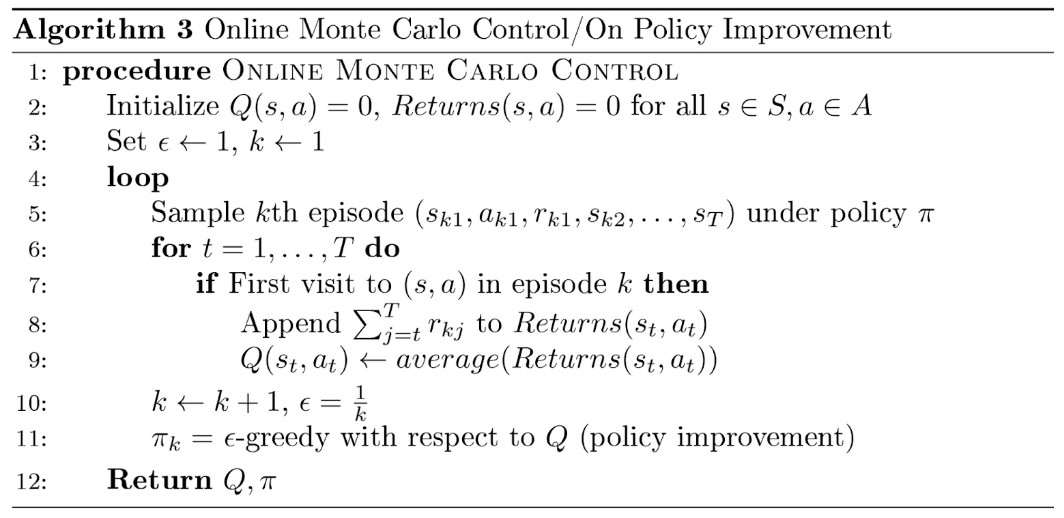

Fig 1: Psuedocode for the Monte Carlo Control algorithm (Hugo LaurençonHugo Laurençon                    6155 bronze badges, 1966)



### A) Obtaining distinct states with
#### observation_to_base4(observation)
We first determine the distinct states that we have in this problem As the observation space of all observations are continous in nature, we divided them into 257 equal intervals to form discrete states where each state corresponds to a combination of discrete observations.


In [ ]:
import math

def observation_to_base4(observations):
  if observations[0]<-2.4 or observations[0]>2.4 or observations[2]<math.radians(-12) or observations[2]>math.radians(12):  # If observations results in termination of episode
    return "10000"
  string = ""
  bins = [[-0.3,0,0.3],[-0.3,0,0.3],[-0.05,0,0.05],[-0.2,0,0.2]]  # A 2-dimensional list (4 by 3) which stores the values used to separate each observation
  for i in range(len(observations)):
    for j in range(len(bins)-1):
      if observations[i] < bins[i][j]:
        string += str(j)
        break
    else:
      string += "3"
  return string     # return the quaternary string

def observation_to_index(observations):
  return int( observation_to_base4(observations) , 4) # return the index mapped from the quaternary string given above ^

### B) Assigning rewards to our various states

For our agent, we first assigned a reward of +1 for every state except for the terminal state which we assigned a reward of 0.

To train the agent more effectively, we improved (Task 4) and modified the rewards such that states (a combination of observations) where the pole is most unlikely to topple over would be given a reward of +10. An example of such a steady state would be when the cart velocity and pole angle is close to 0.


In [ ]:
rewardlist= [1 for _ in range(257)]   ### Initialise all states to have a reward of 1
rewardlist[256] = 0                   ### Terminal state has no reward

optimal_indexes = []     # Initialise a list used to store optimal state indexes where the cartpole should aim to reach
for a in (1,2):          # when observation's 1st value is in the middle bins, E.g. cart position is near 0
  for b in (1,2):        # when observation's 2nd value is in the middle bins, E.g. cart velocity is near 0
    for c in (1,2):      # when observation's 3rd value is in the middle bins, E.g. pole angle is near 0
      for d in (1,2):    # when observation's 4th value is in the middle bins, E.g. pole angular velocity is near 0
        string = str(a)+str(b)+str(c)+str(d)  # resulting quaternary strings
        optimal_indexes.append(int(string,4)) # resulting index mapped from the quaternary strings above ^

for idx in optimal_indexes:
  rewardlist[idx] = 10   # these are the optimal states, where all observation values are close to 0. Give it a higher reward value of 10

### C) Calculating accumulated rewards for an episode trajectory (empirical G(s,a)) with
#### reward_giver(trajectory)

Based on the pseudocode, we are to calculate the accumulated rewards for the first occurence of each state-action (s,a) pair in the trajectory.

This function does that by traversing the trajectory string while summing up (cumulating) the rewards for every distinct (s,a) pair. This would give the accumulated rewards for every (s,a) that appears in the trajectory. The function then returns a dictionary of first visit accumulated rewards for each (s,a) pair that appeared in the episode

In [ ]:
def reward_giver(trajectory): # trajectory is the list of (state,action) tuples taken in the episode. E.g. (145,1) represents, at state 145, action 1 was taken. Note that trajectory stores the last (initial_state,action,end_state) at the start of the list
  episode_rewards = dict()    # Initialise episode_rewards to an empty dictionary. Used to store each (state,action) pair's Q-value for the 1st time this (state,action) pair was visited in the episode
  gamma = 0.99                # gamma value, used to discount the individual rewards by a factor of 0.99 so that sooner rewards count more than later rewards. Also ensures total Q-value remains bounded
  reward_at_step_list = [0 for _ in range(len(trajectory))] # Initialise a list used to store the Q-value at each step

  reward_at_step_list[0] = rewardlist[trajectory[0][2]]     # Sets the 1st Q-value to be the reward given for reaching the last state
  for i in range(1, len(trajectory)):
    reward_at_step_list[i] = rewardlist[(trajectory[i][2])] + reward_at_step_list[i-1]*gamma  # Sets all Q-values to be the reward given for reaching the end_state + gamma*Q-value of previous step

  counter = 0                                                     # Initialise counter to 0
  for j in trajectory:
    episode_rewards[(j[0],j[1])] = reward_at_step_list[counter]
    # (j[0],j[1]) represents (state,action). the episode_rewards dictionary stores the Q-value in the reward_at_step_list in the (state,action) key
    # Since trajectory stores the 1st (initial_state,action,end_state) at the end of the list, the episode_rewards will store the Q-value for the 1st occurence of (state,action) tuple

    counter += 1                                                  # Increment the counter by 1
  return episode_rewards                                          # Returns the dictionary of Q-values for each (state,action) pair


### D) Encouraging Exploration with
#### Epsilon Soft policy



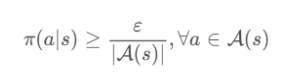

Fig 2: Epsilon Soft policy formula (Difference between epsilon-greedy and epsilon-soft policies, 2020)

The epsilon soft policy was used to first populate our ‘pi’ list (policy) with actions for the very first time. We will be setting ε=1.0 initially, where epsilon refers to the probability of exploration (agent selecting a random action at a certain state s instead of the action that results in the maximum Q(s,a) value).

Our action space A(s) for the cart has two possible actions - move Left or move Right. Since |A(s)| = 2, we decided to let the probability of each action for each state (π(a|s)) be 0.5 and populated our ‘pi’ list accordingly.


#### Epsilon Greedy Policy


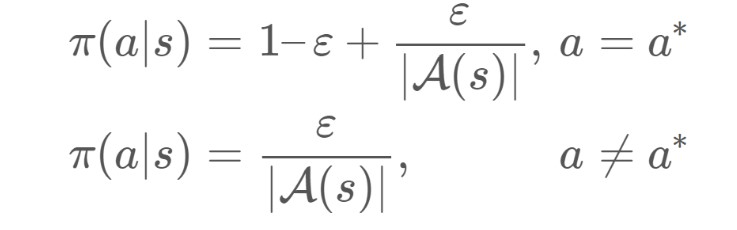

Fig 3: Epsilon Greedy policy formula (Difference between epsilon-greedy and epsilon-soft policies, 2020)

To encourage exploration as we trained the agent, we used the epsilon greedy policy.

This was accomplished with the function *epsilon_greedy(Q, s, epsilon)* which outputs the action the agent should take at a given state according to the epsilon greedy policy.

In addition, we also gradually reduced the value of epsilon with an epsilon decay factor to discourage exploration as the values begin to converge. Starting from ε=1.0, we gradually decrease epsilon with a decay factor of 0.9999 after every episode till ε=0.001 as our policy begins to converge (TORRES.AI, 2021)


#### epsilon_greedy(Q, s, epsilon)

In [ ]:
from random import choices
from operator import add

def epsilon_greedy(Q, s, epsilon):  # Q is the Q-table, s is the state that needs to be updated in the policy
  if np.random.random() < epsilon:    # epsilon chance that this is true. E.g. if epsilon=0.15, there is a 15% chance that this is True
    return np.random.choice((0,1))      # return either 0 or 1, each with a 50% probability
  else:                               # (1-epsilon) chance that this block of statements is triggered. E.g. if epsilon=0.15, there is a 85% chance that this block of statements run
    return np.argmax(Q[s])              # return whichever action (0 or 1) which has a higher Q-value for this state s

### E) Implementing the First Visit Monte Carlo algorithm

Here, we train out agent using the first visit MC algorithm. We iterated the while loop in the algorithm till ε decayed to 0.001 as we found that the average length of each episode began to plateau from around 50000 iterations onwards as seen in the output plot below.

NOTE: as we modified the rewards for states that we deem most steady above, 'cumulative reward' here refers to the reward defined by the original cartpole problem.


By then, our epsilon value would have also decayed to a very small number that is close to 0.

#### Key Data Structures used in our implementation

'qtable' - a 257 x 2 array which stores the value of each state-action pair comprising of 257 states each with 2 actions.
(Each state is derived from the 4 variables each divided into 4 bins. Hence, we arrived with a total of $4^4$ + 1 terminal state = 257 states)

‘pi’  - a list that contains the action the agent should take for each of the different states in the problem. Eventually, this list ‘pi’ will be the answer to the problem.

'count' -  a 257 x 2 array that stores the number of times the empirical Q(s,a) has been averaged. The count value that is stored for each (s,a) pair is to be used in the computation of the average empirical Q(s,a) value for each visited state s in an episode.

'trajectory' - a list used to store the states visited in an episode

'step_list' - a list used to store the number of steps in an episode. This is also used to calculate the average steps in the last 10 episodes which will be seen in the graph we plotted later on.

In [ ]:
a = [0,1]         # A list of possible actions
epsilon = 1       # Initial Episilon value
iteration = 0     # keeps track of iteration count (i.e episode number)

##### Initialise of all data structures #####
qtable = [[0 for _ in range(2)] for _ in range(257)]    # A 2-dimensional (257 by 2) list that stores the average Q-value for each (state,action) pair
count = [[0 for _ in range(2)] for _ in range(257)]     # A 2-dimensional (257 by 2) list that stores the number of Q-values used to calculate the average Q-value for each (state,action) pair
pi = [choices((0,1),(0.5,0.5))[0] for _ in range(257)]  # The policy. It is a 1-dimensional (size 257) list that stores the action to take for each state. It is initialised as a soft policy, storing either 0 or 1 with a probability of 50% chance each for each state
step_list = []                                          # Initialise step_list to an empty list. It is used to store all episodes' cumulative_reward

while epsilon > 0.001:      # minimum epsilon value set by us

  ###### Policy Evaluation Phase ######
  ######   Reset all variables   ######

  iteration += 1            # Tracks which iteration this loop is at
  states_visited = set()    # Initialise the variable states_visited set(). Used to determine which states have been visited so as to update their policy
  observation = env.reset() # Resets the environment and observation variable is given the value that is returned
  cumulative_reward = 0     # Resets cumulative_reward to 0. cumulative_reward is used to track the number of steps the cartpole has taken without falling
  done = False              # Resets done to boolean False. done is used to track whether the episode has ended
  trajectory = []           # Resets the trajectory list to an empty list. Used to store the (state,action) tuples taken by the environment in the episode later
  end_state = observation_to_index(observation) # Initialise end_state variable to be the index from mapped from initial_observation

  # Generating random observations in one episode
  while not done:                                       # While the episode has not ended (OR episode is "not done")
      initial_state = end_state                           # Initial_state is simply the previous end_state
      action = pi[initial_state]                          # Retrieves the policy from pi according to the state calculated above
      observation, reward, done, info = env.step(action)  # Cartpole environment takes the action we chose and returns the resulting observation, reward, done, info values
      end_state = observation_to_index(observation)       # Map the observation after taking the action into a single index
      trajectory.insert( 0, (initial_state,action,end_state) )                 # inserts the (state,action) tuple into the start of the trajectory list
      cumulative_reward += reward                         # reward is 1 if cartpole did not fall. cumulative_reward simply records the number of actions cartpole has taken without falling

  # Give rewards for each state depending on our rewardlist defined above
  episode_rewards = reward_giver(trajectory)


  # Updating qtable by averaging the rewards of all the episodes for the given state-action
  for state_action, reward in episode_rewards.items():  # state_action is the (state,action) tuple that was reached in the episode. reward is the Q-value for its 1st occurence in the episode

    qtable[state_action[0]][state_action[1]] = (qtable[state_action[0]][state_action[1]]*count[state_action[0]][state_action[1]] + reward) / (count[state_action[0]][state_action[1]]+1) # updates the qtable to be the average Q-value of all episodes so far
    count[state_action[0]][state_action[1]] += 1    # The (state,action) that was reached by the episode, increase the count for it by 1
    states_visited.add(state_action[0])             # Adds the state into states_visited since it was visited in the episode

  # Policy Improvement Phase
  for s in states_visited:                      # only call the epsilon_greedy() function to update the policy for the state if the state was visited in the episode
    pi[s] = epsilon_greedy(qtable, s, epsilon)  # call the epsilon_greedy() function to update the policy for the visited state

  #Decaying epsilon value
  epsilon = epsilon*0.9999

  # Adding number of steps to step_list list
  step_list.append(cumulative_reward)

  # Printing output seen below
  if iteration%1000==0:
    print('Episode {:>6d} : {:>3.0f} steps'.format(iteration , cumulative_reward))


Episode   1000 :  10 steps
Episode   2000 :  36 steps
Episode   3000 :  24 steps
Episode   4000 :  99 steps
Episode   5000 :  85 steps
Episode   6000 :  32 steps
Episode   7000 : 143 steps
Episode   8000 :  37 steps
Episode   9000 : 500 steps
Episode  10000 :  46 steps
Episode  11000 : 500 steps
Episode  12000 : 500 steps
Episode  13000 : 500 steps
Episode  14000 : 138 steps
Episode  15000 : 152 steps
Episode  16000 : 378 steps
Episode  17000 : 500 steps
Episode  18000 : 500 steps
Episode  19000 : 500 steps
Episode  20000 : 210 steps
Episode  21000 : 500 steps
Episode  22000 : 500 steps
Episode  23000 : 500 steps
Episode  24000 : 500 steps
Episode  25000 : 500 steps
Episode  26000 : 500 steps
Episode  27000 :  38 steps
Episode  28000 : 500 steps
Episode  29000 : 500 steps
Episode  30000 : 500 steps
Episode  31000 : 500 steps
Episode  32000 : 500 steps
Episode  33000 : 500 steps
Episode  34000 : 500 steps
Episode  35000 : 500 steps
Episode  36000 : 500 steps
Episode  37000 : 500 steps
E

In [ ]:
### This was used for storing our policy that was trained above ^

# import pandas as pd
# from google.colab import files

# df = pd.DataFrame(pi)
# df.to_excel('pi_storage.xlsx', sheet_name="Sheet1",index=False)
# files.download('pi_storage.xlsx')

# df = pd.DataFrame(qtable)
# df.to_excel('qtable_storage.xlsx', sheet_name="Sheet1",index=False)
# files.download('qtable_storage.xlsx')

# df = pd.DataFrame(count)
# df.to_excel('count_storage.xlsx', sheet_name="Sheet1",index=False)
# files.download('count_storage.xlsx')

# df = pd.DataFrame(step_list)
# df.to_excel('step_list_storage.xlsx', sheet_name="Sheet1",index=False)
# files.download('step_list_storage.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Showing the learning process of our agent

Here, we show the cumulative reward (number of steps in an epsiode before terminal states were reached) for every single episode starting from the first till the last when epsilon has decayed to 0.001. The blue line shows the cumulative reward in each epsiode while the orange line shows the average cumulated reward in the last 10 episodes.

We observe that as time progresses, we see less variability in both curves and both cumulative and average cumulative reward represented by both curves converge and plateau off at 500.

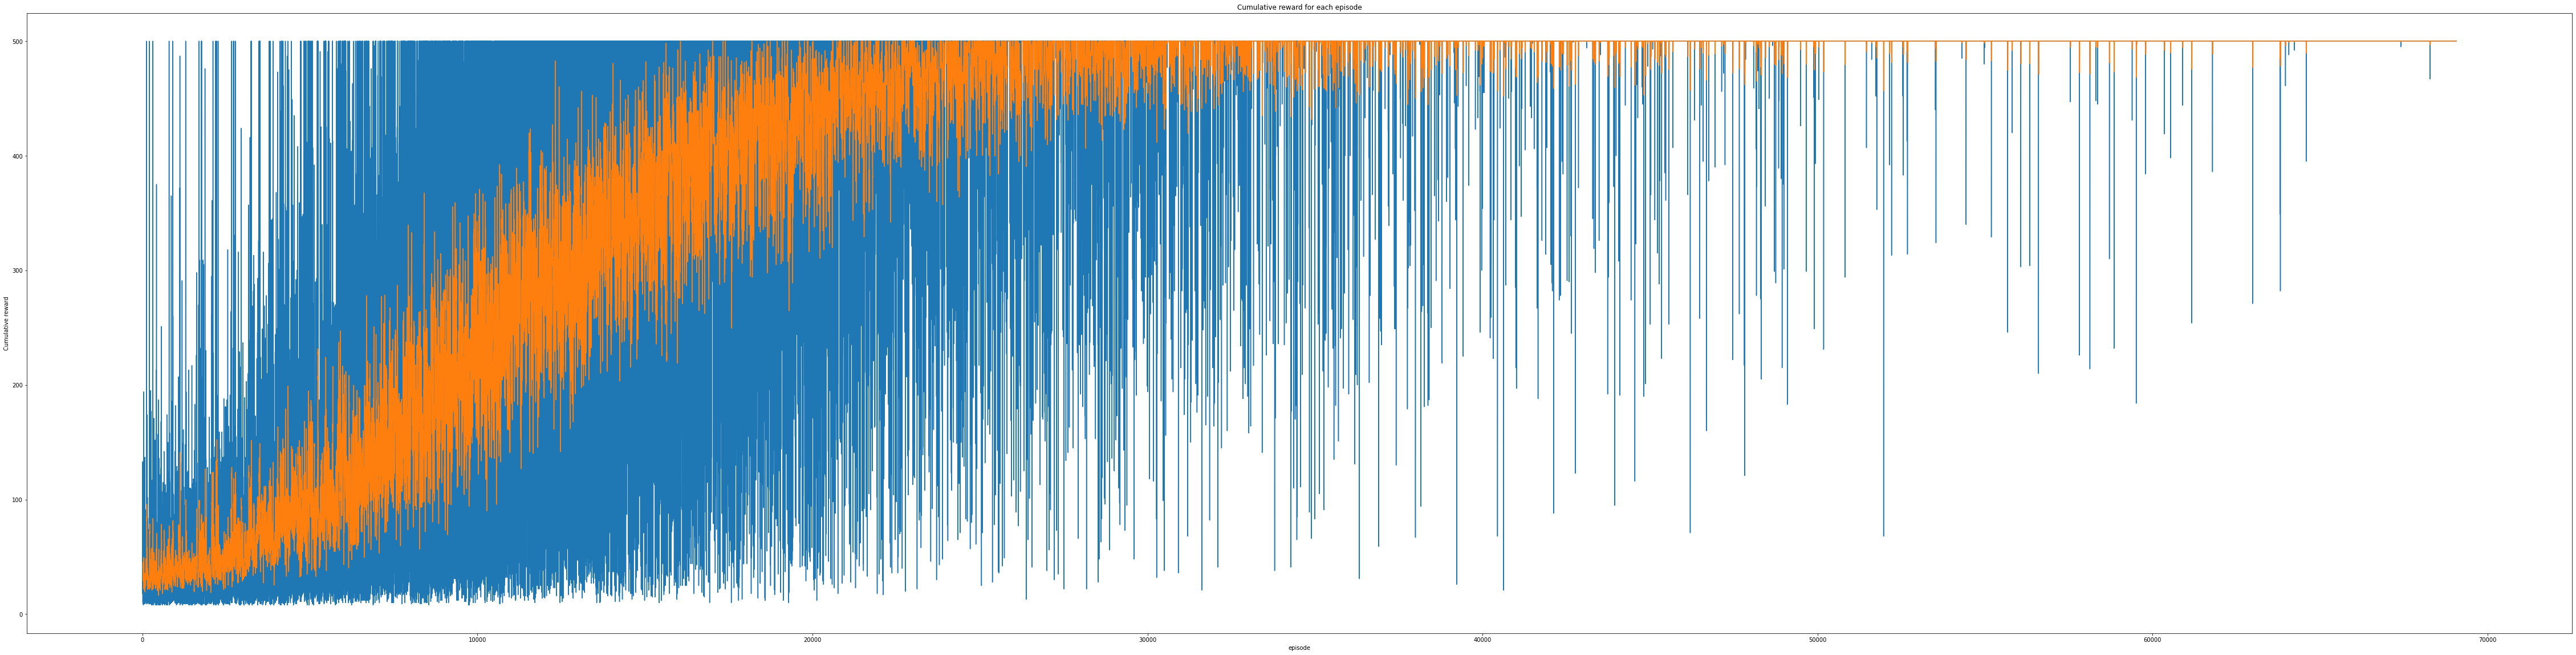

In [ ]:
avg_step = []
for i in range(10,len(step_list)):
  avg_step.append(sum(step_list[i-10:i])/10)

plt.figure(figsize=(80,20))

plt.plot(step_list)
plt.plot(list(range(10,len(step_list))),avg_step)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

## Task 2: Demonstrate the effectiveness of the RL agent

Here, we load our saved policy which is determined by the agent we trained earlier.

NOTE: This was added so that you do not need to re-train the model above to run the following lines of code if you wish to.

Before running the following lines of code, please run the following cells under these headers too:

1. "Importing dependencies and helper functions"
2. "Instantiating an environment"
3. "A) Obtaining distinct states with observation_to_base4(observation)"

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving pi_storage.xlsx to pi_storage (1).xlsx


In [ ]:
pi_storage = pd.read_excel('pi_storage.xlsx').values.tolist()
pi_storage = [i[0] for i in pi_storage]
pi = pi_storage

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

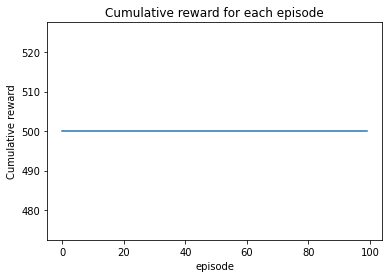

In [ ]:
step_list_1 = []
loops = 100
a = [0,1]

for num in range(loops):
  observation = env.reset()
  done = False
  cumulative_reward = 0
  while not done:
    state = observation_to_index(observation)
    act = pi[state]
    observation, reward, done, info = env.step(act)
    cumulative_reward += reward
  step_list_1.append(cumulative_reward)

plt.plot(step_list_1)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

As seen above, our cumulative reward is constant at 500 for all 100 episodes.

## Task 3: Render one episode played by the agent

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    state = observation_to_index(observation)
    action = pi[state]
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

# References

1. Hugo Laurençon. (2020, January). Why the Monte Carlo Control Algorithm is written this way? Cross Validated. Retrieved March 28, 2023, from https://stats.stackexchange.com/questions/443369/why-the-monte-carlo-control-algorithm-is-written-this-way

2. LazyProgrammer. (2020, February 27). Difference between epsilon-greedy and epsilon-soft policies. What is the difference between epsilon-greedy and epsilon-soft policies? Retrieved March 28, 2023, from https://lazyprogrammer.me/what-is-the-difference-between-epsilon-greedy-and-epsilon-soft-policies/

3. TORRES.AI, J. (2021, May 10). MC control methods. Medium. Retrieved March 28, 2023, from https://towardsdatascience.com/mc-control-methods-50c018271553